In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn import metrics, datasets

# # Initialize data
# cat_features = [0, 1]
# train_data = [["a", "b", 1, 4, 5, 6],
#               ["a", "b", 4, 5, 6, 7],
#               ["c", "d", 30, 40, 50, 60]]
# train_labels = [1, 1, -1]
# eval_data = [["a", "b", 2, 4, 6, 8],
#              ["a", "d", 1, 4, 50, 60]]

def logistic_function(raw_predictions):
    return 1 / (1 + np.exp(-raw_predictions))

data = datasets.fetch_california_housing()

train_data = pd.DataFrame(data["data"], columns = data["feature_names"])
train_labels = data["target"] > data["target"].mean()

cat_features = []

tree_step_size = 5
number_of_iterations = 10
number_of_trees = number_of_iterations * tree_step_size

first = True
boosted_predictions_raw = np.zeros(len(train_labels))
incorrect_boosted_predictions = np.zeros(len(train_labels))

roc_increase = []
roc_step = []
incorrect_offset = []

for iteration in range(0, number_of_iterations):
    
    model = CatBoostClassifier(iterations = tree_step_size,
                               learning_rate = 0.5,
                               depth = 3,
                               silent = True)   

    wrong_model = CatBoostClassifier(iterations = tree_step_size,
                                     learning_rate = 0.5,
                                     depth = 3,
                                     silent = True)
    
    if first:
        model.fit(train_data, train_labels, cat_features)
        wrong_model.fit(train_data, train_labels, cat_features)
        first = False
    else:
        model.fit(train_data, train_labels, cat_features, baseline=boosted_predictions_raw)
        wrong_model.fit(train_data, train_labels, cat_features, baseline=incorrect_boosted_predictions)
        
    
    incorrect_boosted_predictions += wrong_model.predict_proba(train_data)[:, 1]
    predictions_raw = model.predict(train_data, prediction_type = 'RawFormulaVal')
    boosted_predictions_raw += predictions_raw
    
    incorrect_offset.append(metrics.roc_auc_score(train_labels, incorrect_boosted_predictions))
    roc_step.append(metrics.roc_auc_score(train_labels, logistic_function(predictions_raw)))
    roc_increase.append(metrics.roc_auc_score(train_labels, logistic_function(boosted_predictions_raw)))
    

step_predictions = logistic_function(boosted_predictions_raw)

model = CatBoostClassifier(iterations = number_of_trees,
                           learning_rate = 0.5,
                           depth = 3, 
                           silent = True) 

model.fit(train_data, train_labels, cat_features)
full_predictions = model.predict_proba(train_data)[:, 1]

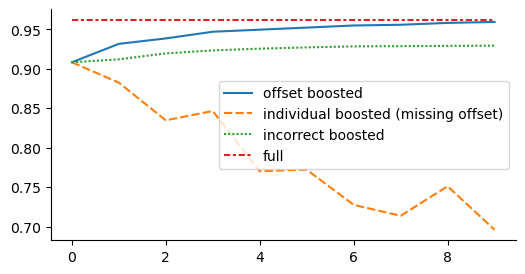

In [2]:
metrics_df = pd.DataFrame({
    "offset boosted": roc_increase,
    "individual boosted (missing offset)": roc_step,
    "incorrect boosted": incorrect_offset,
    "full": metrics.roc_auc_score(train_labels, full_predictions)
})


fig, ax = plt.subplots(figsize=(6, 3))

sns.lineplot(data=metrics_df)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')